In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils
from utils import open_all_FF_tables, MSCF_DAY_TO_KG_HR
from config import PLUMES_PER_SCENE, EMISSIONS_PER_DAY

#### Filepaths + Settings

In [ ]:
START_YEAR = 2019
END_YEAR = 2023

VENT_FILE = "../data/central_appalachian_mine_vent_locations.csv"
EMISSIONS_FILE = f"../data/karacan_2023_VS12.csv"
VS_16_FILE = "../data/karacan_2025_VS16.csv"
VS_12_FILE = "../data/karacan_2025_VS12.csv"
FF_TABLES_FILE = "../data/FF_tables/"

#### Read, merge, and subset data

In [ ]:
vents = utils.read_infrastructure_file(VENT_FILE)
emis = pd.read_csv(EMISSIONS_FILE)

emissions_per_day = pd.read_csv(EMISSIONS_PER_DAY)
emissions_per_day["date"] = pd.to_datetime(emissions_per_day["date"])
emissions_per_day = pd.merge(
    emissions_per_day,
    vents[["vent_id", "vent_type", "Description"]],
    on="vent_id",
    how="right",
)
plumes_per_scene = pd.read_csv(PLUMES_PER_SCENE)
plumes_per_scene = pd.merge(
    plumes_per_scene,
    vents[["vent_id", "vent_type", "Description"]],
    on="vent_id",
    how="right",
)

# drop duplicates created while testing
plumes_per_scene.drop_duplicates(
    subset=["scene_id", "vent_id"], keep="first", inplace=True
)

vs16_bu = pd.read_csv(
    VS_16_FILE,
    parse_dates=["date"],
    date_parser=lambda x: pd.to_datetime(x, format='"%Y-%m-%d"'),
)
vs16_bu = vs16_bu.pivot(index="date", columns="name", values="value").reset_index()

vs12_bu = pd.read_csv(VS_12_FILE, parse_dates=["date"])

epa_vents = open_all_FF_tables(out_dir=FF_TABLES_FILE)["FF_VENTILATION_QTRLY"]
epa_vents = epa_vents[epa_vents.facility_id == 1008387]
epa_vents = epa_vents[epa_vents.reporting_year.isin([2019, 2020, 2021, 2022, 2023])]

Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: BAILEY MINE-CRABAPPLE PORTAL
Fixing number of shafts in: ENLOW FORK MINE
Fixing number of shafts in: HARVEY MINE
Fixing number of shafts in: HARRISON COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: LEER SOUTH MINING COMPLEX


#### Clean data

In [ ]:
# convert to kg/hr
epa_vents["emis_kg_hr"] = epa_vents.qtr_meth_vent_lib * utils.MT_QRT_TO_KG_HR
emis[["mean", "standard_deviation", "minimum", "maximum"]] = (
    emis[["mean", "standard_deviation", "minimum", "maximum"]] * MSCF_DAY_TO_KG_HR
)
emis["units"] = "kg/hr"


vs_cm = emissions_per_day.copy()
# matplotlib.rcParams.update({'font.size': 18})

# they changed the name of VS 16 when they installed the RTO
epa_vents.loc[
    epa_vents["location_of_measurement_conc"] == "Vent Shaft 16 fan ductwork to RTO",
    "location_of_measurement_conc",
] = "Vent Shaft 16"

emis["year"] = emis.quarter_label.str[:4].astype(int)
emis["quarter"] = emis.quarter_label.str[7].astype(int)

epa_vents["year_qtr"] = [
    f"{y} Q{q}"
    for y, q in zip(epa_vents.reporting_year.astype(int), epa_vents.quarter.astype(int))
]
emis["year_qtr"] = [
    f"{y} Q{q}" for y, q in zip(emis.year.astype(int), emis.quarter.astype(int))
]
vs_cm["year_qtr"] = [
    f"{y} Q{q}"
    for y, q in zip(vs_cm.date.dt.year.astype(int), vs_cm.date.dt.quarter.astype(int))
]
vs16_bu["year_qtr"] = [
    f"{y} Q{q}"
    for y, q in zip(
        vs16_bu.date.dt.year.astype(int), vs16_bu.date.dt.quarter.astype(int)
    )
]
vs12_bu["year_qtr"] = [
    f"{y} Q{q}"
    for y, q in zip(
        vs12_bu.date.dt.year.astype(int), vs12_bu.date.dt.quarter.astype(int)
    )
]

#### Plot

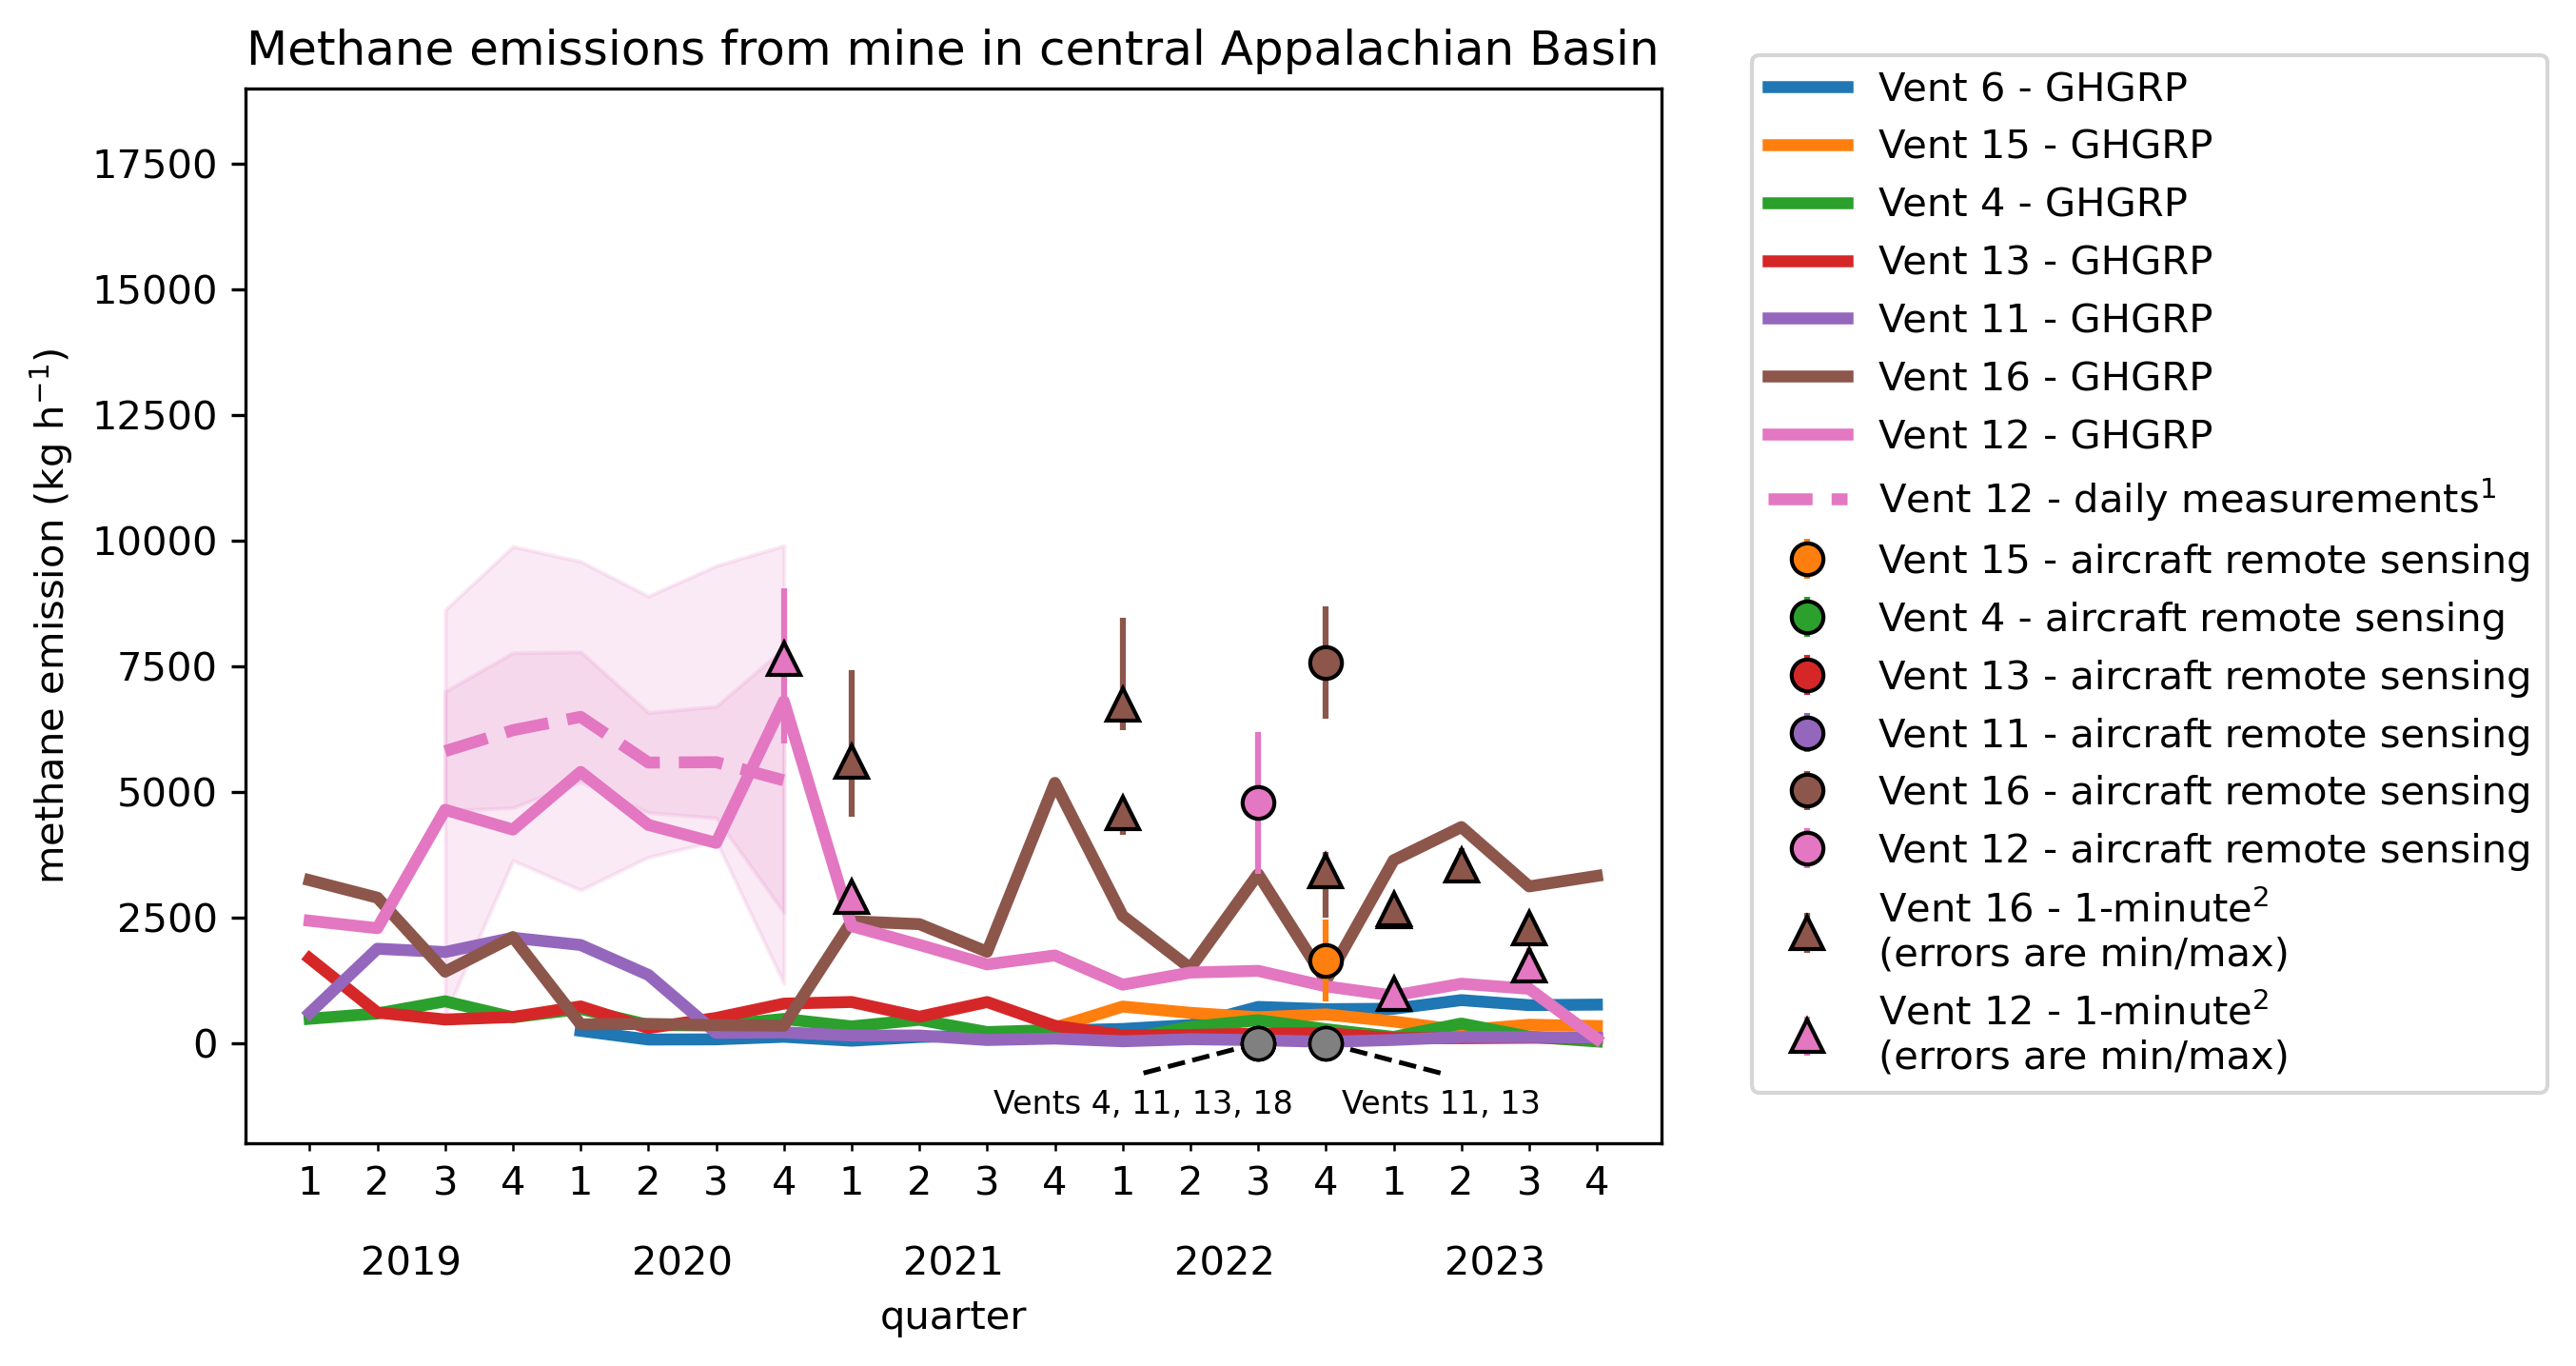

In [ ]:
plt.figure(dpi=300)
sorted_x = epa_vents.sort_values(by=["reporting_year", "quarter"], ascending=True)[
    ["reporting_year", "quarter", "year_qtr"]
].drop_duplicates()
plt.plot(sorted_x.year_qtr, np.full(len(sorted_x.year_qtr), np.nan), color="k")

all_vent_names = np.array(
    [
        "Vent Shaft 6",
        "Vent Shaft 15",
        "Vent Shaft 4",
        "Vent Shaft 13",
        "Vent Shaft 11",
        "Vent Shaft 16",
        "Vent Shaft 12",
    ]
)
for vent_name in all_vent_names:
    legend_name = f"Vent {vent_name.replace('Vent Shaft ', '')}"
    vs = epa_vents[
        (epa_vents["location_of_measurement_conc"] == vent_name)
        & (epa_vents["reporting_year"] <= END_YEAR)
        & (epa_vents["reporting_year"] >= START_YEAR)
    ].sort_values(by=["reporting_year", "quarter"], ascending=True)
    emis = emis[(emis["year"] <= END_YEAR) & (emis["year"] >= START_YEAR)].sort_values(
        by=["year", "quarter"], ascending=True
    )
    p = plt.plot(
        vs.year_qtr, vs.emis_kg_hr, linewidth=3, label=f"{legend_name} - GHGRP"
    )
    this_vs_cm = vs_cm[
        (vs_cm.Description == f"{vent_name.replace('Vent Shaft ', '')} Vent")
        & (vs_cm.date.dt.year <= END_YEAR)
        & (vs_cm.date.dt.year >= START_YEAR)
    ]
    if not np.all(this_vs_cm.emission_auto.isnull()):
        plt.errorbar(
            this_vs_cm.year_qtr,
            this_vs_cm.emission_auto,
            yerr=this_vs_cm.emission_uncertainty_auto,
            fmt="o",
            label=f"{legend_name} - aircraft remote sensing",
            color=p[0].get_color(),
            markersize=8,
            markeredgecolor="black",
            zorder=100,
        )

# VS 16
vent_name = "16 Vent"
vs16_color = "tab:brown"
vs16_bu_errors = np.stack(
    (
        (vs16_bu.max_value - vs16_bu.mean_value).values,
        (vs16_bu.mean_value - vs16_bu.min_value).values,
    )
)
plt.errorbar(
    vs16_bu.year_qtr,
    vs16_bu.mean_value,
    yerr=vs16_bu_errors,
    fmt="^",
    label="Vent 16 - 1-minute$^2$\n(errors are min/max)",
    markersize=8,
    color=vs16_color,
    markeredgecolor="black",
)

# VS 12
vent_name = "12 Vent"
vs12_color = "tab:pink"
vs12_bu_errors = np.stack(
    ((vs12_bu.ub - vs12_bu.mean_value).values, (vs12_bu.mean_value - vs12_bu.lb).values)
)
plt.errorbar(
    vs12_bu.year_qtr,
    vs12_bu.mean_value,
    yerr=vs12_bu_errors,
    fmt="^",
    label="Vent 12 - 1-minute$^2$\n(errors are min/max)",
    markersize=8,
    color=vs12_color,
    markeredgecolor="black",
)
plt.plot(
    emis.year_qtr[1:-1],
    emis["mean"][1:-1],
    linewidth=3,
    color=vs12_color,
    linestyle="--",
    label="Vent 12 - daily measurements$^1$",
)
plt.fill_between(
    x=emis.year_qtr[1:-1],
    y1=emis.minimum[1:-1],
    y2=emis.maximum[1:-1],
    color=vs12_color,
    alpha=0.15,
)
plt.fill_between(
    x=emis.year_qtr[1:-1],
    y1=emis["mean"][1:-1] - emis.standard_deviation[1:-1],
    y2=emis["mean"][1:-1] + emis.standard_deviation[1:-1],
    color=vs12_color,
    alpha=0.15,
)

# custom year/quarter x axis
quarter_labels = list(sorted_x.quarter.astype(int).astype(str))
quarter_ticks = plt.gca().get_xticks()
plt.gca().set_xticks(quarter_ticks, minor=True)
plt.gca().set_xticklabels(quarter_labels, minor=True)
year_labels = [
    f"\n\n{y}" for y in sorted_x.reporting_year.astype(int).astype(str).unique()
]
year_ticks = list(np.array(plt.gca().get_xticks())[::4] + 1.5)
plt.gca().set_xticks(year_ticks)
plt.gca().set_xticklabels(year_labels)
plt.gca().tick_params(axis="x", which="major", length=0)  # hide ticks for years

# Get x-position for overlapping quarters
year_qtr_list = sorted_x.year_qtr.tolist()
x_q3 = year_qtr_list.index("2022 Q3")
x_q4 = year_qtr_list.index("2022 Q4")

plt.legend(bbox_to_anchor=(1.05, 1.05), loc="upper left")
plt.title("Methane emissions from mine in central Appalachian Basin")
plt.ylabel("methane emission (kg h$^{-1})$")
plt.xlabel("quarter")
plt.ylim(-2000, 19000)

# Callout line for overlapping measurements in 2022 Q3, Q4
# Get x-position for overlapping quarters
year_qtr_list = sorted_x.year_qtr.tolist()
x_q3 = year_qtr_list.index("2022 Q3")
x_q4 = year_qtr_list.index("2022 Q4")
# Offsets
text_y_offset = -900
line_y_offset = -600
x_offset_q3 = -1.7  # slightly farther left
x_offset_q4 = 1.7  # slightly farther right
# Slightly smaller gray dots for visibility of original border
plt.scatter([x_q3], [0], color="gray", s=40, zorder=200)  # s=40 instead of 60
plt.scatter([x_q4], [0], color="gray", s=40, zorder=200)
# Diagonal black callout lines
plt.plot(
    [x_q3, x_q3 + x_offset_q3],
    [0, line_y_offset],
    color="black",
    linewidth=1.2,
    linestyle="--",
    zorder=199,
)
plt.plot(
    [x_q4, x_q4 + x_offset_q4],
    [0, line_y_offset],
    color="black",
    linewidth=1.2,
    linestyle="--",
    zorder=199,
)
# Annotations
plt.text(
    x_q3 + x_offset_q3,
    text_y_offset,
    "Vents 4, 11, 13, 18",
    ha="center",
    va="top",
    fontsize=8,
    zorder=201,
)
plt.text(
    x_q4 + x_offset_q4,
    text_y_offset,
    "Vents 11, 13",
    ha="center",
    va="top",
    fontsize=8,
    zorder=201,
)

plt.savefig('./figures/figure_S1.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
emissions_per_day[emissions_per_day.emission_auto == 0].sort_values(
    by="date", ascending=True
)

,vent_id,date,emission_auto,emission_uncertainty_auto,observed,plume_id,scene_id,vent_type,Description
332,193,2022-09-29,0.0,50.000000,True,NaN,ang20220929t194238,Ventilation Shaft,13 Vent
404,195,2022-09-29,0.0,35.355339,True,"nan, nan","ang20220929t182318, ang20220929t175528",Ventilation Shaft,4 Vent
476,196,2022-09-29,0.0,35.355339,True,"nan, nan","ang20220929t194238, ang20220929t180755",Ventilation Shaft,11 Vent
548,198,2022-09-29,0.0,50.000000,True,NaN,ang20220929t174215,Ventilation Shaft,18 Vent
331,193,2022-10-14,0.0,50.000000,True,NaN,ang20221014t185154,Ventilation Shaft,13 Vent
475,196,2022-10-14,0.0,50.000000,True,NaN,ang20221014t185154,Ventilation Shaft,11 Vent
